In [1]:
import sys
import os
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('./introduction.ipynb'))))

There are four cases
- Single treatment, single outcomes
- Single treatment, multiple outcomes
- Multiple treatments, single outcome
- Multiple treatments, multiple outcomes

For outcomes, we may also consider the combinations of continuous and discrete outcomes.

In [2]:
# Helper imports 
import numpy as np
from numpy.random import binomial, multivariate_normal, normal, uniform
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingRegressor
import matplotlib.pyplot as plt
import pandas as pd

from ylearn.estimator_model.meta_learner import SLearner, TLearner, XLearner
from ylearn.estimator_model.doubly_robust import DoublyRobust
from ylearn.utils import to_df
%matplotlib inline

In [3]:
# Define DGP
def generate_data(n, d, controls_outcome, treatment_effect, propensity):
    """Generates population data for given untreated_outcome, treatment_effect and propensity functions.
    
    Parameters
    ----------
        n (int): population size
        d (int): number of covariates
        controls_outcome (func): untreated outcome conditional on covariates
        treatment_effect (func): treatment effect conditional on covariates
        propensity (func): probability of treatment conditional on covariates
    """
    # Generate covariates
    X = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n)
    # Generate treatment
    T = np.apply_along_axis(lambda x: binomial(1, propensity(x), 1)[0], 1, X)
    # Calculate outcome
    Y0 = np.apply_along_axis(lambda x: controls_outcome(x), 1, X)
    treat_effect = np.apply_along_axis(lambda x: treatment_effect(x), 1, X)
    Y = Y0 + treat_effect * T
    return (Y, T, X)

In [4]:
def generate_controls_outcome(d):
    beta = uniform(-3, 3, d)
    return lambda x: np.dot(x, beta) + normal(0, 1)
treatment_effect = lambda x: (1 if x[1] > 0.1 else 0)*8
propensity = lambda x: (0.8 if (x[2]>-0.5 and x[2]<0.5) else 0.2)
# DGP constants and test data
d = 5
n = 1000
n_test = 250
controls_outcome = generate_controls_outcome(d)
X_test = multivariate_normal(np.zeros(d), np.diag(np.ones(d)), n_test)
delta = 6/n_test
X_test[:, 1] = np.arange(-3, 3, delta)

In [5]:
y, x, w = generate_data(n, d, controls_outcome, treatment_effect, propensity)
data_dict = {
    'outcome': y,
    'treatment': x,
}
test_dict = {}
adjustment = []
for i in range(w.shape[1]):
    data_dict[f'w_{i}'] = w[:, i].squeeze()
    test_dict[f'w_{i}'] = X_test[:, i].squeeze()
    adjustment.append(f'w_{i}')
outcome = 'outcome'
treatment = 'treatment'
data = pd.DataFrame(data_dict)
test_data = pd.DataFrame(test_dict)


## SLearner

In [6]:
s = SLearner(model=GradientBoostingRegressor())
s.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
)
s_pred = s.estimate(data=test_data, quantity=None)

In [7]:
s1 = SLearner(model=GradientBoostingRegressor())
s1.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
    combined_treatment=False
)
s1_pred = s1.estimate(data=test_data, quantity=None)

## TLearner

In [8]:
t = TLearner(
    model=GradientBoostingRegressor()
)
t.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
)
t_pred = t.estimate(data=test_data, quantity=None)

In [9]:
t1 = TLearner(
    model=GradientBoostingRegressor()
)
t1.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
    combined_treatment=False,
)
t1_pred = t1.estimate(data=test_data, quantity=None)

## XLearner

In [10]:
x = XLearner(
    model=GradientBoostingRegressor()
)
x.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
)
x_pred = x.estimate(data=test_data, quantity=None)

In [11]:
x1 = XLearner(
    model=GradientBoostingRegressor()
)
x1.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    adjustment=adjustment,
    combined_treatment=False,
)
x1_pred = x1.estimate(data=test_data, quantity=None)

## DoublyRobust Model

In [12]:
dr = DoublyRobust(
    x_model=RandomForestClassifier(n_estimators=100, max_depth=100, min_samples_leaf=int(n/100)),
    y_model=GradientBoostingRegressor(n_estimators=100, max_depth=100, min_samples_leaf=int(n/100)),
    yx_model=GradientBoostingRegressor(n_estimators=100, max_depth=100, min_samples_leaf=int(n/100)),
    cf_fold=1,
    random_state=2022,
)
dr.fit(
    data=data,
    outcome=outcome,
    treatment=treatment,
    covariate=adjustment,
)
dr_pred = dr.estimate(data=test_data, quantity=None).squeeze()

### Result for MetaLearners when combined_treatment=True

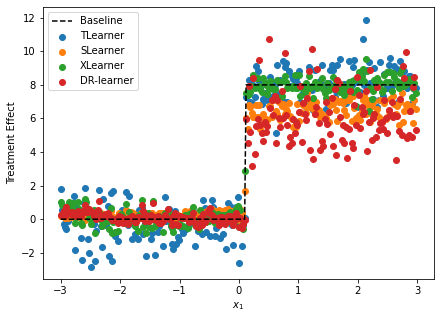

In [13]:
plt.figure(figsize=(7, 5))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='Baseline')
plt.scatter(X_test[:, 1], t_pred, label="TLearner")
plt.scatter(X_test[:, 1], s_pred, label="SLearner")
plt.scatter(X_test[:, 1], x_pred, label="XLearner")
plt.scatter(X_test[:, 1], dr_pred, label="DR-learner")
# plt.ylim(-5, 13)
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()

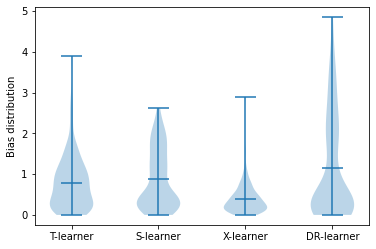

In [14]:
expected_te = np.apply_along_axis(treatment_effect, 1, X_test)
plt.violinplot([np.abs(t_pred - expected_te), 
                np.abs(s_pred - expected_te),
                np.abs(x_pred - expected_te),
                np.abs(dr_pred - expected_te)
               ], showmeans=True)
plt.ylabel("Bias distribution")
plt.xticks([1, 2, 3, 4,], ['T-learner', 'S-learner', 'X-learner', 'DR-learner'])
plt.show()

### Result for MetaLearners when combined_treatment=False

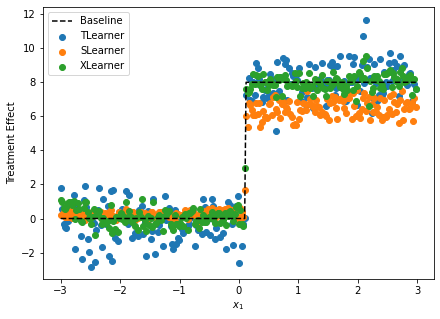

In [15]:
plt.figure(figsize=(7, 5))
plt.plot(X_test[:, 1], np.apply_along_axis(treatment_effect, 1, X_test), color='black', ls='--', label='Baseline')
plt.scatter(X_test[:, 1], t1_pred, label="TLearner")
plt.scatter(X_test[:, 1], s1_pred, label="SLearner")
plt.scatter(X_test[:, 1], x1_pred, label="XLearner")
# plt.scatter(X_test[:, 1], dr_pred, label="DR-learner")
plt.xlabel('$x_1$')
plt.ylabel('Treatment Effect')
plt.legend()
plt.show()